In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from bliss.datasets.pair_sim import generate_pair_dataset

from bliss.datasets.lsst import prepare_final_galaxy_catalog, get_default_lsst_psf
from bliss.reporting import get_residual_measurements, get_deblended_reconstructions

import matplotlib.pyplot as plt
from bliss.catalog import FullCatalog, TileCatalog, turn_samples_into_catalogs
import pytorch_lightning as pl

import torch
import numpy as np 

from tqdm import tqdm

# Loading and organizing

In [ ]:
import torch
import matplotlib.pyplot as plt
from bliss.datasets.lsst import APERTURE_BACKGROUND

In [ ]:
ds =torch.load("../../figures/pair_sim/central_sim_results_1.pt")

In [ ]:
ds.keys()

dict_keys(['outs', 'bld', 'true_snr', 'true_flux', 'true_plocs', 'images'])

In [ ]:
ds['outs'][0].keys()

dict_keys(['nonzero_locs', 'sample_plocs', 'n_sources_samples', 'det_prob', 'sample_fluxes', 'idx', 'n_sources_map', 'map_flux', 'map_plocs'])

In [ ]:
print(len(ds['outs']))
print(ds['bld'].shape)

10000
torch.Size([10000])


In [ ]:
# need to sort things first!!!!
sorted_indices = [out['idx'] for out in ds['outs']]
true_fluxes = ds['true_flux'][sorted_indices][:, 0, 0]
bld = ds['bld'][sorted_indices]
true_snr = ds['true_snr'][sorted_indices][:, 0, 0]
true_fluxes.shape, bld.shape, true_snr.shape

(torch.Size([10000]), torch.Size([10000]), torch.Size([10000]))

In [ ]:
samples_fluxes = torch.stack([out['sample_fluxes'] for out in ds['outs']])
map_fluxes = torch.tensor([out['map_flux'] for out in ds['outs']])
samples_fluxes.shape, map_fluxes.shape, true_fluxes.shape

(torch.Size([10000, 100]), torch.Size([10000]), torch.Size([10000]))

In [ ]:
# discard all examples with all NaNs samples 
mask = ~torch.isnan(samples_fluxes).all(dim=1)
samples_fluxes = samples_fluxes[mask]
map_fluxes = map_fluxes[mask]
true_fluxes = true_fluxes[mask]
true_snr = true_snr[mask]
bld = bld[mask]
samples_fluxes.shape, map_fluxes.shape, true_fluxes.shape, true_snr.shape

(torch.Size([9947, 100]),
 torch.Size([9947]),
 torch.Size([9947]),
 torch.Size([9947]))

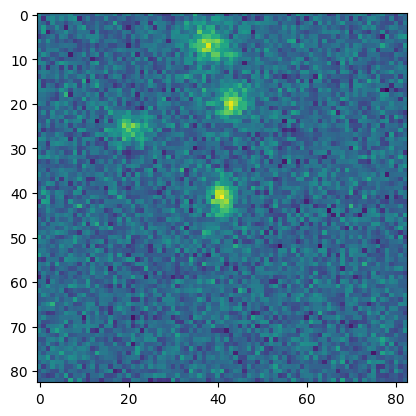

In [ ]:
plt.imshow(ds['images'][66,0])

# Sanity checks

In [ ]:
# check snr computation?
from bliss.datasets.io import load_dataset_npz
dataset = load_dataset_npz("../../data/datasets/central_sim_dataset_1.npz")

In [ ]:
torch.all(dataset['galaxy_params'][:, 0, -2].ravel()< 25.3)

tensor(True)

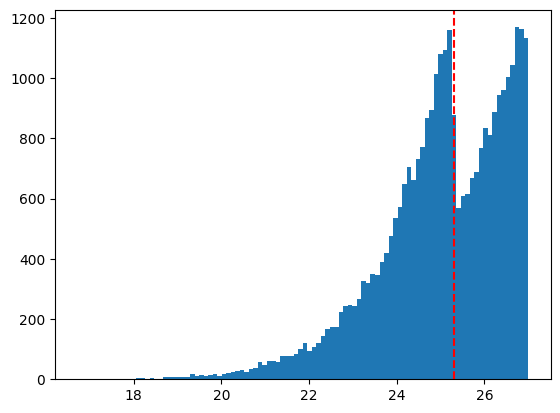

In [ ]:
mags = dataset['galaxy_params'][:, :, -2].ravel()
mask = mags > 0 
plt.hist(mags[mask], bins=100);
plt.axvline(25.3, color='red', linestyle='--')

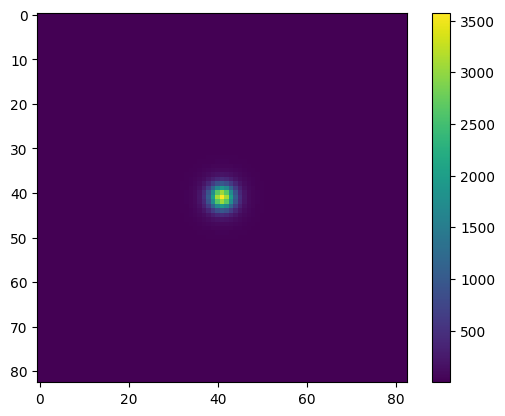

In [ ]:
plt.imshow(dataset['uncentered_sources'][0, 0, 0])
plt.colorbar()


In [ ]:
# im1 = ds["uncentered_sources"]
# im2 = ds["uncentered_sources"].sum(dim=1)
# blendedness = get_blendedness(im1, im2)
# assert blendedness.shape == (n_images, max_n_sources)
# bld = blendedness[:, 0]  # only keep central galaxy for now
# assert bld.ndim == 1


In [ ]:
truth = FullCatalog(
    35,
    35,
    {
        "n_sources": dataset["n_sources"],
        "plocs": dataset["plocs"],
        "galaxy_bools": dataset["galaxy_bools"],
    },
)

In [ ]:
true_meas = get_residual_measurements(
    truth,
    dataset["images"],
    paddings=dataset["paddings"],
    sources=dataset["uncentered_sources"],
    no_bar=False,
)

Measuring galaxies: 100%|██████████| 10000/10000 [00:36<00:00, 271.14it/s]


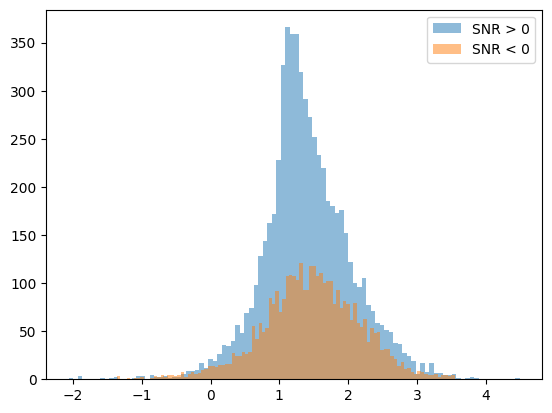

In [ ]:
snr1 = true_meas['snr'][:, 0, 0]
mask_plus = snr1 > 0
mask_minus = snr1 < 0
plt.hist(snr1[mask_plus].log10(), bins=100, alpha=0.5, label='SNR > 0');
plt.hist(snr1[mask_minus].abs().log10(), bins=100, alpha=0.5, label='SNR < 0');
plt.legend()

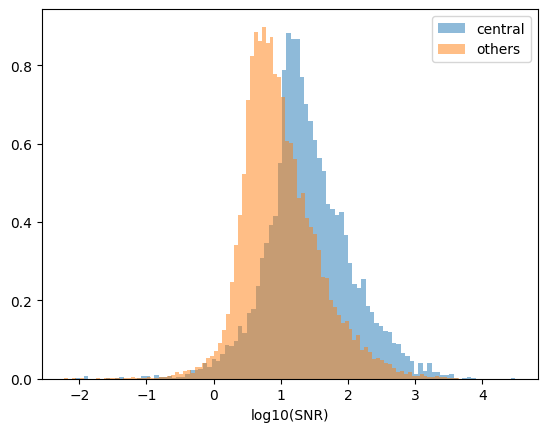

In [ ]:
snr1 = true_meas['snr'][:, 0, 0]
snr2 = true_meas['snr'][:, 1:, 0].ravel()
mask2 = snr2.abs() > 0 

plt.hist(snr1.log10(), bins=100, alpha=0.5, label='central', density=True)
plt.hist(snr2[mask2].log10(), bins=100, alpha=0.5, label='others', density=True)
plt.xlabel('log10(SNR)')
plt.legend()

In [ ]:
true_meas['flux'][mask_minus, 0, 0]

tensor([ -144898.9219, -1228899.8750,   -85066.3750,  ...,
         -174337.6406,  -243531.9688,  -138311.6250])

In [ ]:
dataset['uncentered_sources'].shape

torch.Size([10000, 10, 1, 83, 83])

tensor(4)


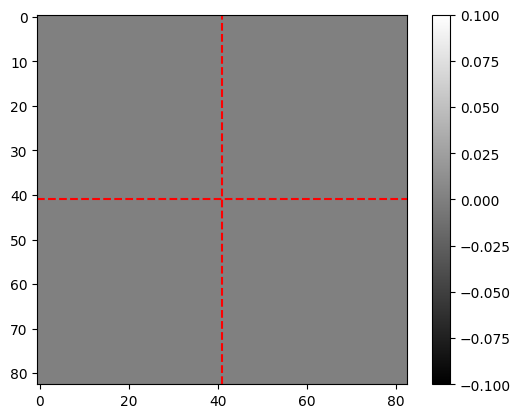

In [ ]:
idx = 11
print(dataset['n_sources'][idx])
image = dataset['images'][idx][0]
other_sources = dataset['uncentered_sources'][idx,5:, 0].sum(0)
padding = dataset['paddings'][idx, 0]
plt.imshow(other_sources, cmap='gray')
plt.colorbar()
plt.axvline(83//2, color='red', linestyle='--')
plt.axhline(83//2, color='red', linestyle='--')

# Histograms

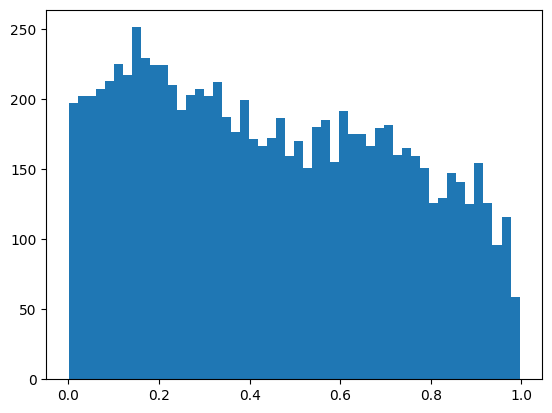

In [ ]:
_mask = bld > 0
plt.hist(bld[_mask], bins=50);

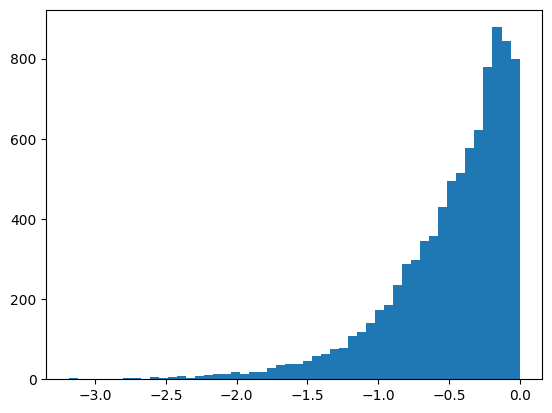

In [ ]:
_mask = bld > 0
plt.hist(bld[_mask].log10(), bins=50);

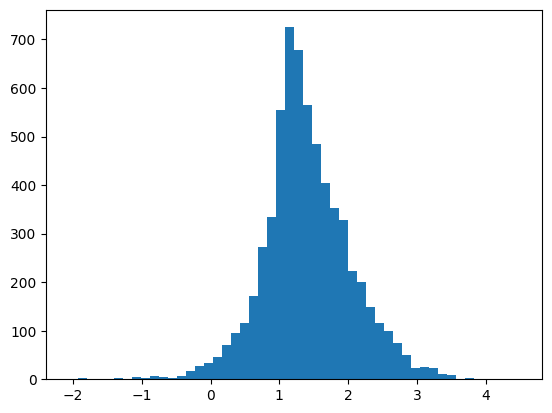

In [ ]:
# snr histogram
plt.hist(true_snr.log10(), bins=50);

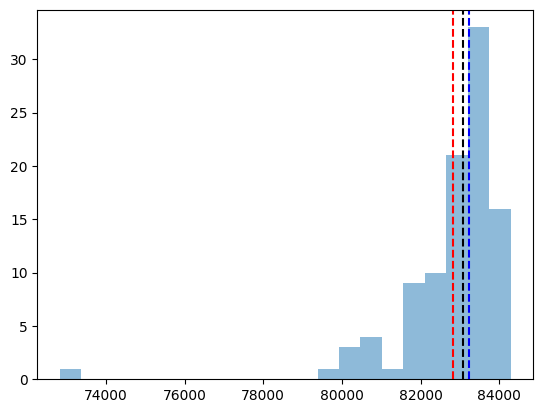

In [ ]:
# check one sample 
idx = 41
plt.hist(samples_fluxes[idx].numpy(), bins=21, alpha=0.5, label='Sample Fluxes')
plt.axvline(samples_fluxes[idx].nanmean().item(), color='red', linestyle='--', label='Mean Sample Flux')
plt.axvline(true_fluxes[idx].item(), color='k', linestyle='--', label='True Flux')
plt.axvline(map_fluxes[idx].item(), color='blue', linestyle='--', label='Map Flux')

# Preliminary results

In [ ]:
res1 = (samples_fluxes.nanmean(dim=1) - true_fluxes) / (true_fluxes + APERTURE_BACKGROUND)
res2 = (map_fluxes - true_fluxes) / (true_fluxes + APERTURE_BACKGROUND)
res1.shape, res2.shape

(torch.Size([9947]), torch.Size([9947]))

In [ ]:
res1[:10], res1.nanmean()

(tensor([-0.0003, -0.0106, -0.0074, -0.0056,  0.0054, -0.0024,  0.0014, -0.0295,
         -0.0396, -0.0003]),
 tensor(-0.9580))

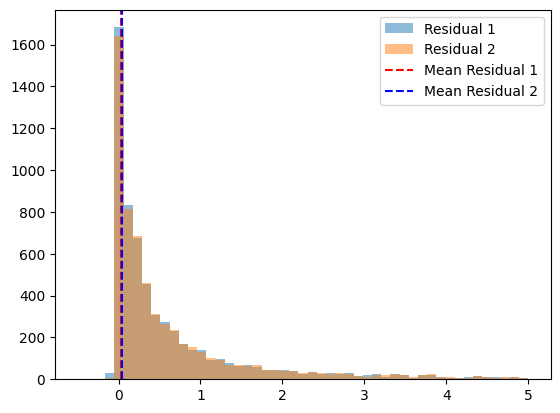

In [ ]:
bins = np.linspace(-0.5, 5, 50)

_ = plt.hist(res1, bins=bins, alpha=0.5, label='Residual 1')
plt.hist(res2, bins=bins, alpha=0.5, label='Residual 2')
plt.axvline(res1.nanmedian().item(), color='red', linestyle='--', label='Mean Residual 1')
plt.axvline(res2.nanmedian().item(), color='blue', linestyle='--', label='Mean Residual 2')
plt.legend()

In [ ]:
res1.nanmedian(), res2.nanmedian()

(tensor(0.0301), tensor(0.0386))

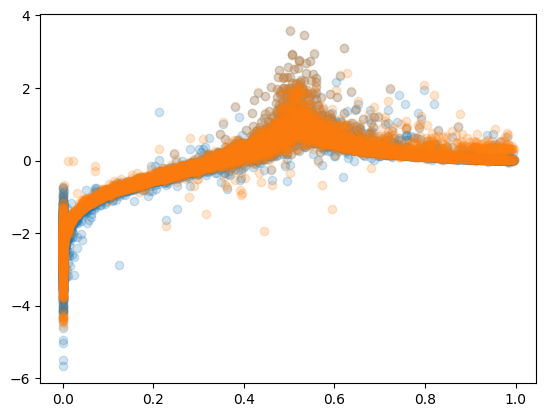

In [ ]:
# as a function of blendedness
plt.scatter(bld, res1.abs().log10(), alpha=0.2, label='Residual 1')
plt.scatter(bld, res2.abs().log10(), alpha=0.2, label='Residual 2')
# plt.ylim(-1, 1)

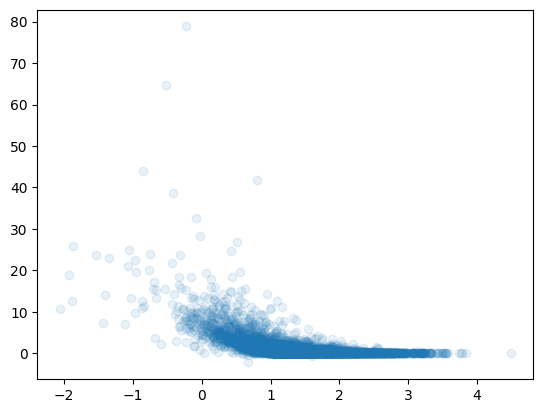

In [ ]:
# snr
plt.scatter(true_snr.log10(), res1, alpha=0.1, label='Residual 1')
# plt.ylim(-1, 1)

# Standard deviation

In [ ]:
# now divided by residuals
plt.figure(figsize=(8, 6))
z_score =  (samples_fluxes.nanmean(dim=1) - true_fluxes) / (stds + APERTURE_BACKGROUND)
plt.hist(
    z_score.numpy(),bins=50, alpha=0.5, label='Z-score of Sample Fluxes'
    );
plt.xlabel('Z-score')

RuntimeError: The size of tensor a (9947) must match the size of tensor b (6273) at non-singleton dimension 0

<Figure size 800x600 with 0 Axes>

Text(0, 0.5, 'Z-score')

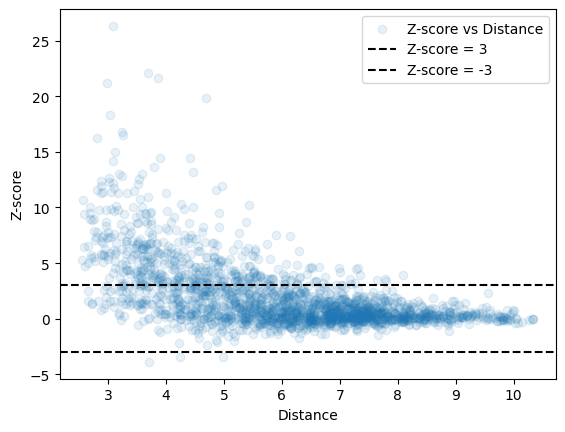

In [ ]:
plt.scatter(dist, z_score.numpy(), alpha=0.1, label='Z-score vs Distance')
plt.axhline(3, color='k', linestyle='--', label='Z-score = 3')
plt.axhline(-3, color='k', linestyle='--', label='Z-score = -3')
plt.legend()
plt.xlabel('Distance')
plt.ylabel('Z-score')

Text(0, 0.5, 'Z-score')

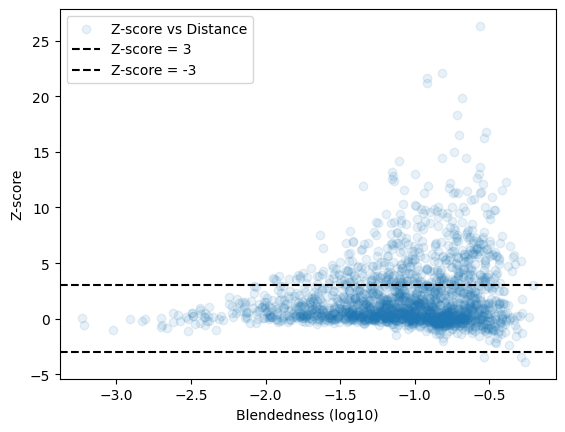

In [ ]:
plt.scatter(bld.log10(), z_score.numpy(), alpha=0.1, label='Z-score vs Distance')
plt.axhline(3, color='k', linestyle='--', label='Z-score = 3')
plt.axhline(-3, color='k', linestyle='--', label='Z-score = -3')
plt.legend()
plt.xlabel('Blendedness (log10)')
plt.ylabel('Z-score')

# Equally sized bins

In [ ]:
from bliss.plotting import equal_sized_bin_statistic
from bliss.datasets.lsst import APERTURE_BACKGROUND

In [ ]:
res1 = (samples_fluxes.nanmean(dim=1) - true_fluxes) / (true_fluxes + APERTURE_BACKGROUND)
res2 = (map_fluxes - true_fluxes) / (true_fluxes + APERTURE_BACKGROUND)
res1.shape, res2.shape

(torch.Size([9947]), torch.Size([9947]))

In [ ]:
stds = [] 
for ii in range(len(samples_fluxes)):
    mask = ~torch.isnan(samples_fluxes[ii])
    if mask.sum() > 1:
        stds.append(torch.std(samples_fluxes[ii][mask]).item())
    else: 
        stds.append(torch.nan)
stds= torch.tensor(stds)
stds.shape

torch.Size([9947])

In [ ]:
z_score =  (samples_fluxes.nanmean(dim=1) - true_fluxes) / (stds + APERTURE_BACKGROUND)
z_score.shape

torch.Size([9947])

In [ ]:
mask_all = ~torch.isnan(true_snr) & (true_snr > 10) & ~torch.isnan(bld) & ~torch.isnan(res1) & ~torch.isnan(res2) & ~torch.isnan(z_score) & ~torch.isnan(stds)

res1 = res1[mask_all]
res2 = res2[mask_all]
z_score = z_score[mask_all]
bld = bld[mask_all]
true_snr = true_snr[mask_all]
stds = stds[mask_all]


In [ ]:
sum(mask_all)

tensor(4922)

In [ ]:
map_fluxes.isnan().sum(), stds.isnan().sum(), true_fluxes.isnan().sum()

(tensor(90), tensor(0), tensor(0))

In [ ]:
res1.isnan().sum(), z_score.isnan().sum(), res2.isnan().sum()

(tensor(0), tensor(0), tensor(0))

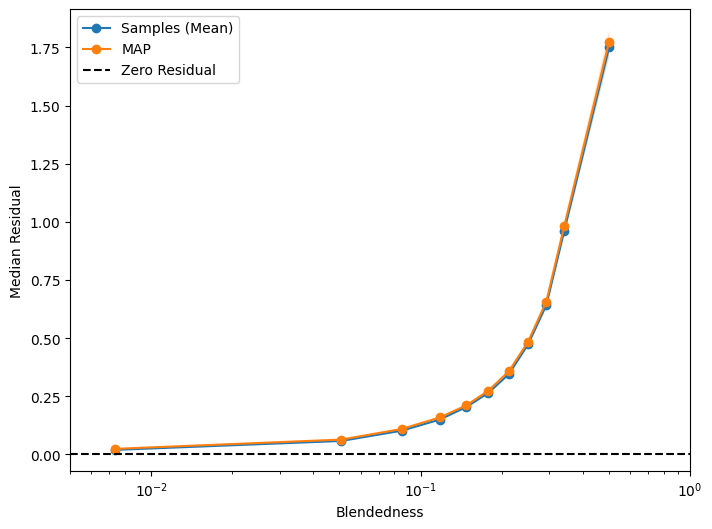

In [ ]:
# same but blendedness (log space)
n_bins = 11
b_dict1_bld = equal_sized_bin_statistic(
    x=bld.log10(),
    y=res1,
    n_bins=n_bins,
    xlims=(-3, -0.1), 
    statistic='median'
)
b_dict2_bld = equal_sized_bin_statistic(
    x=bld.log10(),
    y=res2,
    n_bins=n_bins,
    xlims=(-3, -0.1), 
    statistic='median'
)
plt.figure(figsize=(8, 6))
assert torch.all(b_dict1_bld['middles'] == b_dict2_bld['middles'])

x = 10**b_dict1_bld['middles']

plt.plot(x, b_dict1_bld['stats'], label='Samples (Mean)', marker='o')
plt.fill_between(
    x,
    b_dict1_bld['stats'] - b_dict1_bld['errs'],
    b_dict1_bld['stats'] + b_dict1_bld['errs'],
    alpha=0.2,
)
plt.plot(x, b_dict2_bld['stats'], label='MAP', marker='o')
plt.fill_between(
    x,
    b_dict2_bld['stats'] - b_dict2_bld['errs'],
    b_dict2_bld['stats'] + b_dict2_bld['errs'],
    alpha=0.2,
)
plt.xlabel('Blendedness')
plt.ylabel('Median Residual')
plt.axhline(0, color='k', linestyle='--', label='Zero Residual')
plt.xscale('log')
plt.xlim(10**-2 * 0.5, 1)
plt.legend()
# plt.yscale('log')
# plt.ylim(0, 1)

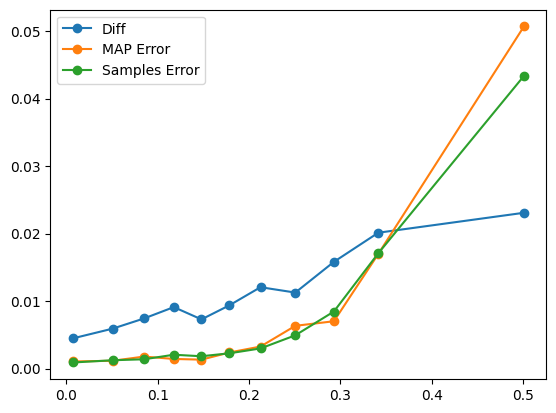

In [ ]:
plt.plot(x, b_dict2_bld['stats'] - b_dict1_bld['stats'], label='Diff', marker='o')
plt.plot(x, b_dict2_bld['errs'], '-o', label='MAP Error')
plt.plot(x, b_dict1_bld['errs'], '-o', label='Samples Error')
plt.legend()

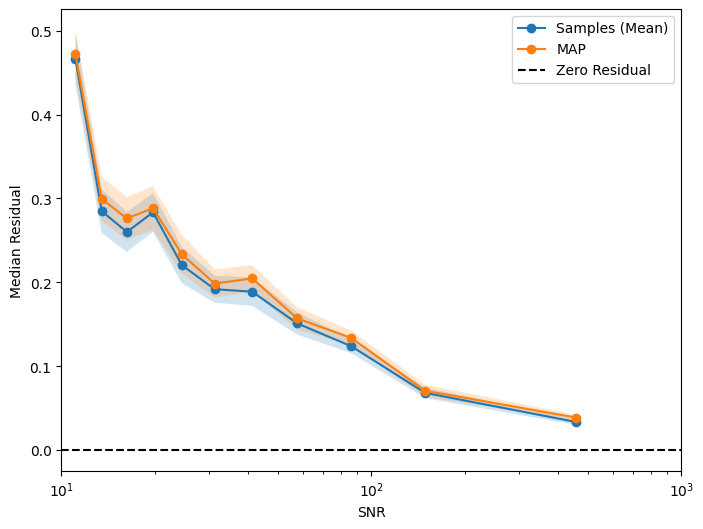

In [ ]:
# now snr 
n_bins = 11
b_dict1_snr = equal_sized_bin_statistic(
    x=true_snr.log10(),
    y=res1,
    n_bins=n_bins,
    xlims=(1.0, 3), 
    statistic='median'
)
b_dict2_snr = equal_sized_bin_statistic(
    x=true_snr.log10(),
    y=res2,
    n_bins=n_bins,
    xlims=(1.0, 3), 
    statistic='median'
)
assert torch.all(b_dict1_snr['middles'] == b_dict2_snr['middles'])
x = 10**b_dict1_snr['middles']


plt.figure(figsize=(8, 6))
plt.plot(x, b_dict1_snr['stats'], label='Samples (Mean)', marker='o')
plt.fill_between(
   x,
    b_dict1_snr['stats'] - b_dict1_snr['errs'],
    b_dict1_snr['stats'] + b_dict1_snr['errs'],
    alpha=0.2,
)
plt.plot(x, b_dict2_snr['stats'], label='MAP', marker='o')
plt.fill_between(
    x,
    b_dict2_snr['stats'] - b_dict2_snr['errs'],
    b_dict2_snr['stats'] + b_dict2_snr['errs'],
    alpha=0.2,
)
plt.xlabel('SNR')
plt.ylabel('Median Residual')
plt.axhline(0, color='k', linestyle='--', label='Zero Residual')
plt.legend()
plt.xlim(10, 1000)
plt.xscale('log')

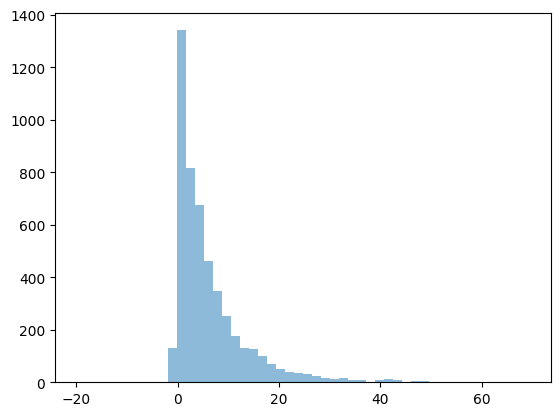

In [ ]:
plt.hist(z_score.numpy(), bins=50, alpha=0.5, label='Z-score of Sample Fluxes');

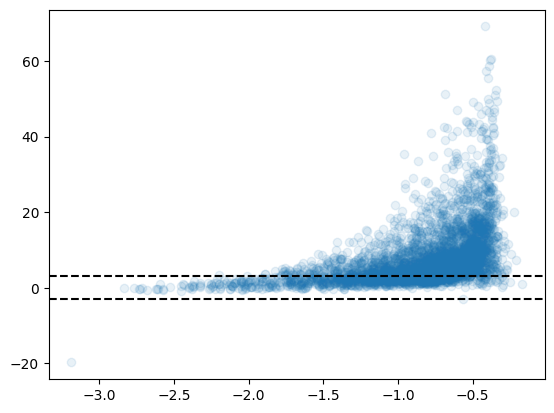

In [ ]:
plt.scatter(bld.log10(), z_score.numpy(), alpha=0.1, label='Z-score vs Blendedness')
plt.axhline(3, color='k', linestyle='--', label='Z-score = 3')
plt.axhline(-3, color='k', linestyle='--', label='Z-score = -3')